# Diabetes prediction: gradient boosting

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from disk

Load the pre-processed data from the decision tree notebook:

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df=dataset['training']
testing_df=dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
611,3,174.0,58.0,22.0,194.000000,32.9,0.593,36,1
648,11,136.0,84.0,35.0,130.000000,28.3,0.260,42,1
717,10,94.0,72.0,18.0,55.433185,23.1,0.595,56,0
527,3,116.0,74.0,15.0,105.000000,26.3,0.107,24,0
392,1,131.0,64.0,14.0,415.000000,23.7,0.389,21,0


## 2. Model training

### 2.1. Previous scores

In [ ]:
# Load cross validation scores from previous models
with open(config.CROSS_VAL_SCORES_FILE, 'rb') as input_file:
    cross_val_scores = pickle.load(input_file)

### 2.2. Gradient boosting model

In [8]:
model=GradientBoostingClassifier()
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy=accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Accuracy of gradient boosting model: {accuracy:.1f}%')

Accuracy of gradient boosting model: 95.9%


In [9]:
cross_val_scores={
    'Model': [],
    'Score': []
}

scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 74.3 +/- 4.3%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter search

In [10]:
%%time

hyperparameters = {
    'n_estimators': randint(2, 200),
    'criterion':['friedman_mse', 'squared_error'],
    'max_depth':randint(1, 20),
    'min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'max_features':uniform(loc=0.1, scale=0.9),
    'min_impurity_decrease':loguniform(10**-5, 1.0),
    'ccp_alpha':loguniform(10**-5, 1.0)
}

search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    hyperparameters,
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    n_iter=100
)

search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
model = search_results.best_estimator_
hyperparameters = search_results.best_params_

print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 0.0006371504785083191
 criterion: friedman_mse
 max_depth: 2
 max_features: 0.6569900845047284
 min_impurity_decrease: 9.283234014397694e-05
 min_weight_fraction_leaf: 0.32199125424613484
 n_estimators: 148

CPU times: user 531 ms, sys: 43 ms, total: 574 ms
Wall time: 21.3 s


### 3.2. Hyperparameter optimization results

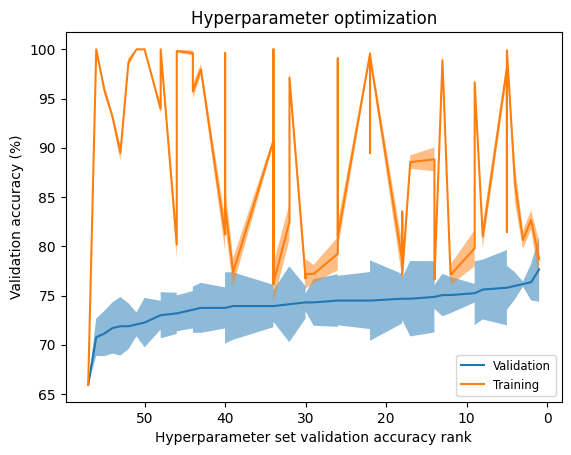

In [11]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [12]:
scores = cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 76.2 +/- 3.8%


## 4. Evaluation

### 4.1. Model comparison

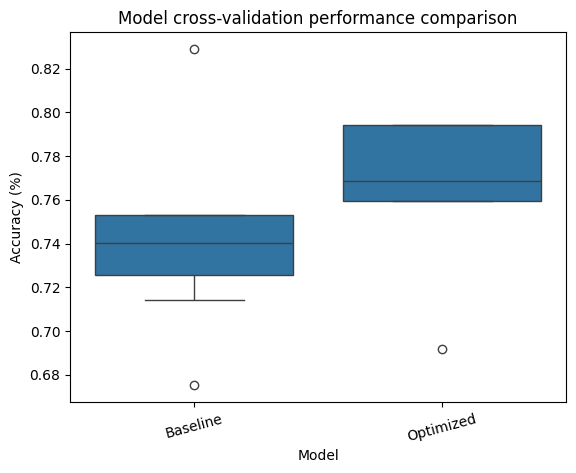

In [13]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)
plt.show()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

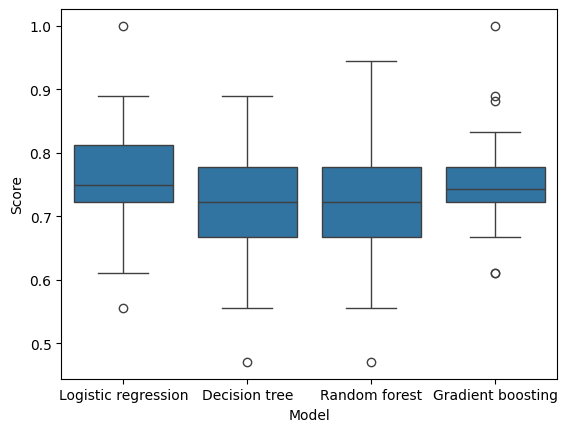

In [14]:
models = {}

models['Logistic regression'] = LogisticRegression().fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree'] = pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest'] = pickle.load(input_file)

models['Gradient boosting'] = model

cross_val_scores = {
    'Model': [],
    'Score': []
}

for model_name, model in models.items():

    scores = cross_val_score(
        model,
        training_df.drop('Outcome', axis=1),
        training_df['Outcome'],
        cv=30,
        n_jobs=-1
    )

    cross_val_scores['Model'].extend([model_name]*len(scores))
    cross_val_scores['Score'].extend(scores)

sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.show()

### 5.3. Test set performance

#### 5.3.1. Load the models

In [ ]:
models = {}

models['Logistic regression'] = LogisticRegression().fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree'] = pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest'] = pickle.load(input_file)

models['Gradient boosting'] = model

#### 5.3.2. Evaluate each model

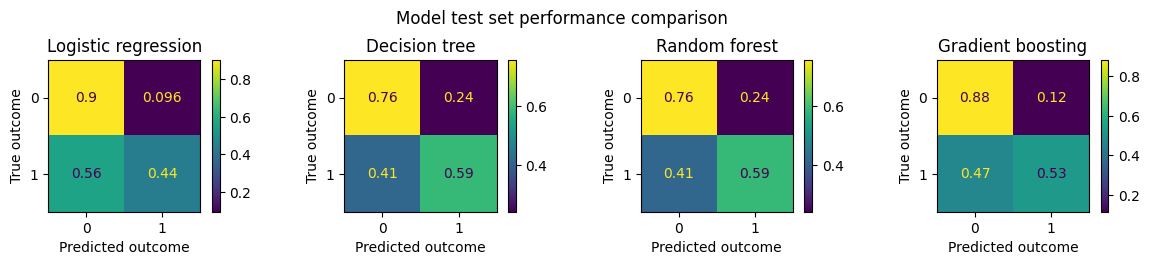

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12,2.5))
axs = axs.flatten()

fig.suptitle(f'Model test set performance comparison')

for i, (model_name, model) in enumerate(models.items()):

    testing_predictions = model.predict(testing_df.drop('Outcome', axis=1))
    accuracy = accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Plot the confusion matrix
    cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    _ = cm_disp.plot(ax=axs[i])

    axs[i].set_title(model_name)
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()

## 6. Save

### 6.1. Cross-validation scores

In [ ]:
with open(config.CROSS_VAL_SCORES_FILE, 'wb') as output_file:
    pickle.dump(cross_val_scores, output_file)

### 6.2. Optimized hyperparameters

In [16]:
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.3. Model

In [17]:
with open(config.GRADIENT_BOOSTING_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)